In [2]:
import jax
jax.config.update("jax_enable_x64", True)   # turn this on to use double precision JAX
import jax.numpy as jnp
from jax import jit
import jax.random as jr
from jax.experimental import sparse
import time
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr

In [3]:
# Simulation parameters
N           = 256
Nt          = 64000
# Du, Dv, F, K = 0.14, 0.06, 0.035, 0.065 # bacteria
# Du, Dv, F, K = 0.16, 0.08, 0.060, 0.062  # coral
# Du, Dv, F, K = 0.12, 0.08, 0.020, 0.050 # spirals
Du, Dv, F, K = 0.16, 0.08, 0.035, 0.060 # zebra fish

seed       = 5678
N2, r = int(N/2), 16
key = jr.PRNGKey(seed)
u_key, v_key = jr.split(key, 2)

In [4]:
@jit
def laplacian():
    main_diag = -4*jnp.ones(N**2)
    od1 = jnp.ones(N**2-1).at[N-1::N].set(0) 
    od2 = jnp.ones(N**2-1).at[N-1::N].set(0) 
    od3 = jnp.ones(N**2-N)
    od4 = jnp.ones(N**2-N)
    
    rows,  cols  = jnp.diag_indices(N**2)
    idx  = jnp.column_stack((rows, cols))
    idx1 = jnp.column_stack((rows.at[:-1].get(), cols.at[1:].get()))
    idx2 = jnp.column_stack((rows.at[1:].get(), cols.at[:-1].get()))
    idx3 = jnp.column_stack((rows.at[:-N].get(), cols.at[N:].get()))
    idx4 = jnp.column_stack((rows.at[N:].get(), cols.at[:-N].get()))
    
    data = jnp.concatenate([main_diag,od1,od2,od3,od4])
    idxs = jnp.concatenate([idx,idx1,idx2,idx3,idx4])
    
    return sparse.BCOO((data, idxs), shape=(N**2, N**2))

In [5]:
@jit
def update_sim(t,vals):
    u,v,L = vals
    uvv = u*v*v
    u += (Du*jnp.dot(L,u) - uvv +  F *(1-u))
    v += (Dv*jnp.dot(L,v) + uvv - (F+K)*v  )
    return u,v,L
update_sim_sp = sparse.sparsify(update_sim)

In [6]:
@jit
def do_simulation(u, v):   
    L = laplacian()
    u, v, L = jax.lax.fori_loop(0, Nt, update_sim_sp, init_val=(u,v,L))    
    return u, v

In [7]:
# Initialize
u = jnp.ones((N, N),dtype=jnp.float64)
v = jnp.zeros((N, N),dtype=jnp.float64)
u += 0.02*jr.uniform(u_key,(N,N))
v += 0.02*jr.uniform(v_key,(N,N))
u = u.at[N2-r:N2+r, N2-r:N2+r].set(0.50)
v = v.at[N2-r:N2+r, N2-r:N2+r].set(0.25)
u = u.reshape((N**2))
v = v.reshape((N**2))

start = time.time()
u,v = do_simulation(u, v)
end = time.time()
print(f"Computation time: {end - start}")

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Computation time: 121.2403154373169


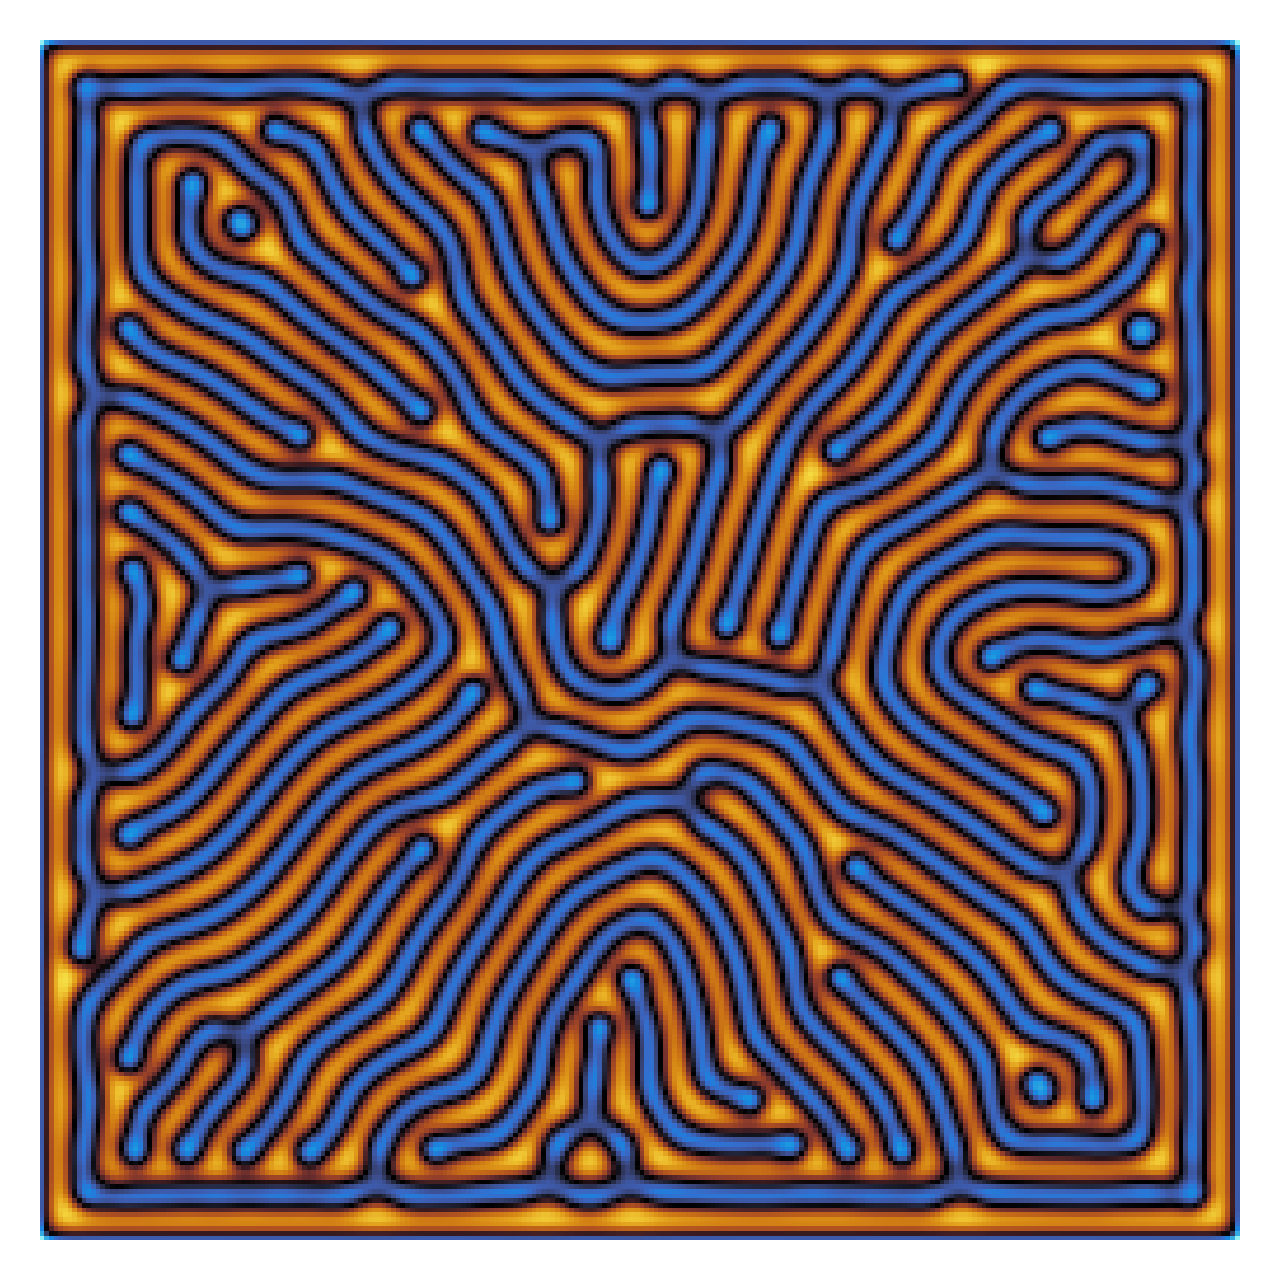

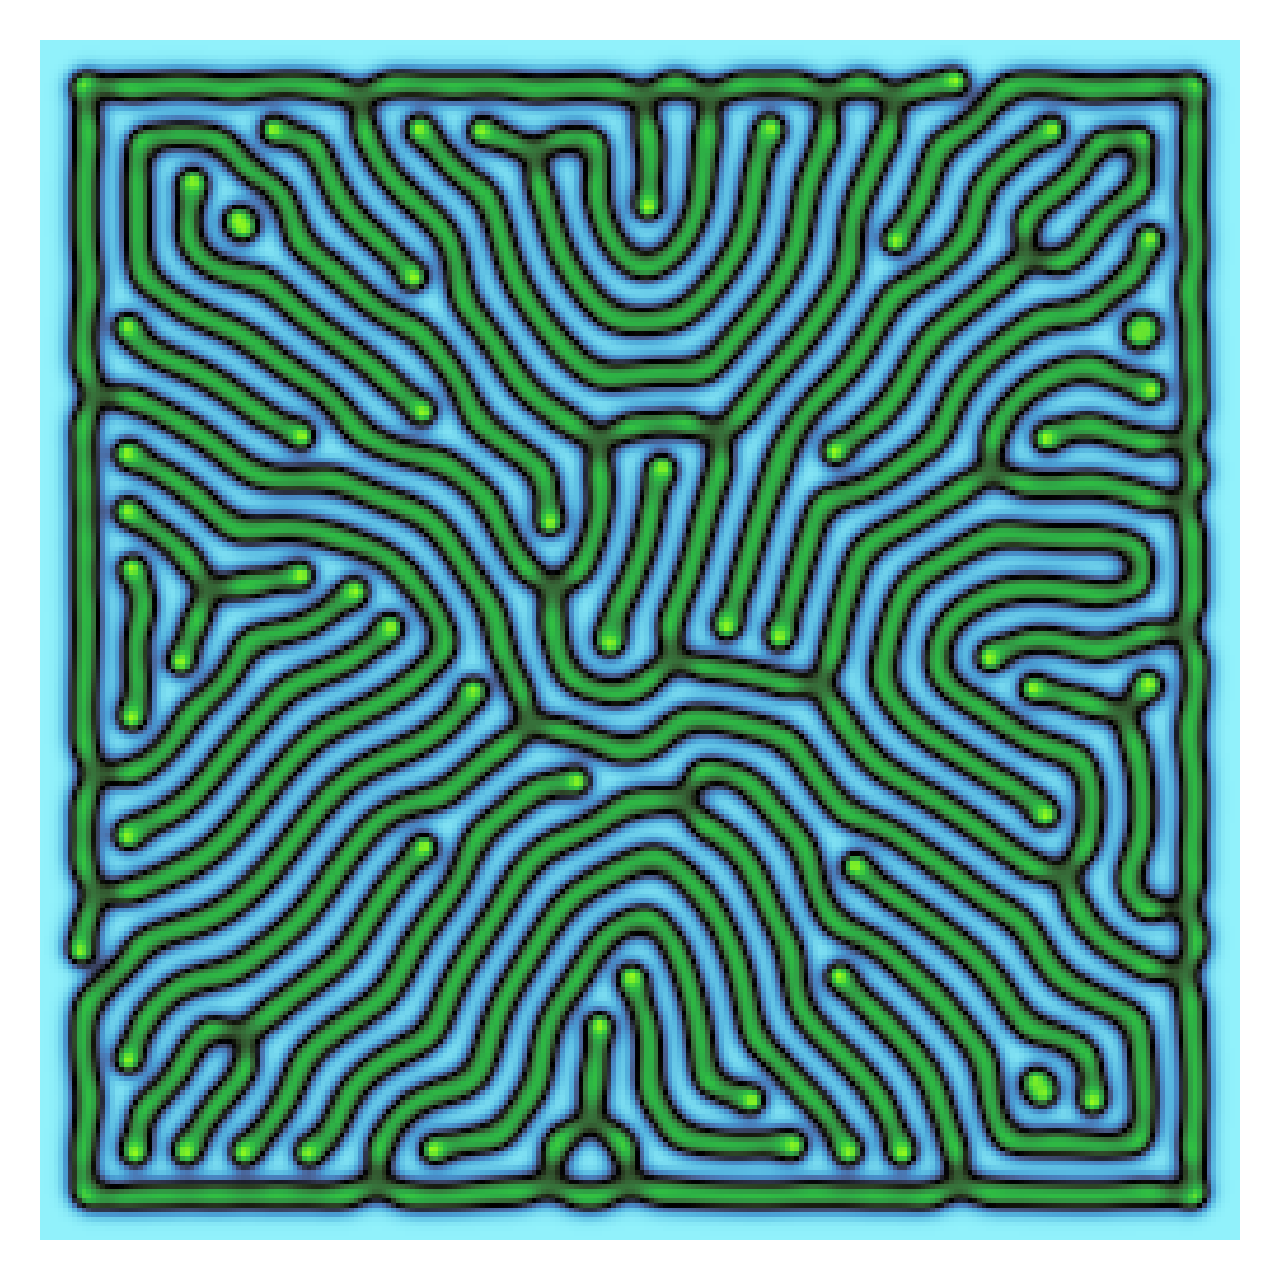

In [8]:
f = plt.figure(figsize=(3,3), dpi=400, frameon=False)
ax = plt.Axes(f, [0., 0., 1., 1.])
ax.set_axis_off()
f.add_axes(ax)
ax.pcolor(u.reshape((N, N)), cmap=cmr.iceburn)
# plt.savefig('plots_diffusion/zebrafish_A.png',dpi=400)
plt.show()

f = plt.figure(figsize=(3,3), dpi=400, frameon=False)
ax = plt.Axes(f, [0., 0., 1., 1.])
ax.set_axis_off()
f.add_axes(ax)
ax.pcolor(v.reshape((N, N)), cmap=cmr.seaweed)
# f.savefig('plots_diffusion/zebrafish_B.png',dpi=400)
plt.show()